# Backtesting Introduction

This notebook intends to explain you how to use the `Backtester` class that `soam` provides by illustrating a simple and generic example.

### Database used
We will be using a database that stores information on Apple's and Tesla's stocks over a period of time.

In [1]:
from soam.workflow.time_series_extractor import TimeSeriesExtractor
from muttlib.dbconn import get_client
import pandas as pd
from soam.models.prophet import SkProphet
import warnings
warnings.filterwarnings('ignore')

import logging, sys
logging.disable(sys.maxsize)

Importing plotly failed. Interactive plots will not work.


## Establish connection with the database and retrieve the pandas DataFrame we will use

In [21]:
sqlite_cfg = {
    "db_type": "sqlite",
    "database": "soam_quickstart.db"
}

sqlite_client = get_client(sqlite_cfg)[1]
extractor = TimeSeriesExtractor(db=sqlite_client, table_name='stock')
query={
    'columns': '*',
    'extra_where_conditions': ["symbol = 'AAPL'"],
    'dimensions': ['date']
    
}
df = extractor.run(build_query_kwargs = query)
df = df[['date', 'avg_price']]
df.rename(columns = {
    'date': 'ds',
    'avg_price': 'y'}, inplace = True)
df.ds = pd.to_datetime(df.ds)
df.head()

,ds,y
0,2021-03-01,125.0
1,2021-03-02,126.0
2,2021-03-03,123.0
3,2021-03-04,121.0
4,2021-03-05,119.0


## Basic backtesting

We will use the built in `SkProphet` model to generate a forecasting model and measure it's performance over several points. Later, we will observe how the selected metrics distribute through time by plotting a several line-plots.

In [11]:
from soam.workflow import (
    Backtester,
    Transformer,
    DummyDataFrameTransformer
)
from sklearn.metrics import mean_absolute_error, mean_squared_error
from soam.models.prophet import SkProphet
from soam.workflow.forecaster import Forecaster

### Initiate the forecasting model

In [16]:
my_model = SkProphet()
forecaster = Forecaster(my_model)

### Backtest the model
Train the model with past data and compute metrics.

        Parameters
        ----------
        time_series: pd.DataFrame
            Data used to train and evaluate the data.
        forecaster : soam.Forecaster
            Forecaster that will be fitted and execute the predictions.
        preprocessor: Transformer
            Provide an interface to transform pandas DataFrames.
        forecast_plotter: ForecastPlotterTask
            Plot forecasts.
        test_window: pd.Timedelta
            Time range to be extracted from the main timeseries on which the model will
            be evaluated on each backtesting run.
            If `None` then `forecaster.output_length` is be used.
        train_window: pd.Timedelta, optional
            Time range on which the model will trained on each backtesting run.
            If a pd.Timedelta value is passed then the sliding method will be used to
            select the training data.
            If `None` then the full time series will be used. This is the expanding
            window method.
        step_size: int
            Distance between each successive step between the beginning of each
            forecasting
            range. If None defaults to test_window.
        metrics: dict(str, callable)
            `dict` containing name of a metric and a callable to compute it.
            The callable must conform to the interface used by sklearn for regression
            metrics:
            https://scikit-learn.org/stable/modules/classes.html#regression-metrics
        aggregation: bool or dict
            The expected aggregations for the results.
            If set to true will use the default aggregation, this keeps the last plot,
            and calculates the average, minimum and maximum for the different metrics.
            If it's a dict the PLOT_KEYWORD is expected to be assigned to the index
            of the selected plot. METRICS_KEYWORD is expected to be another dictionary
            containing the name of the aggregation associated with the function to
            aggregate de list of values per metric.
            If aggregation is set to False or None, no aggregation would be performed.


#### In this case we will use:
- A `dummy` transformation for preprocessing.
- `Mean Absolute Error` and `Mean Squared Error` as performance metrics.
- Train window of 5 days.
- Test window of 1 day.
- Our built in `SkProphet` forecasting model.

In [22]:
backtester = Backtester(forecaster=forecaster,
                        train_window=5,
                        test_window=1,
                        preprocessor=Transformer(DummyDataFrameTransformer()),
                        metrics={
                            'mae': mean_absolute_error,
                            'mse': mean_squared_error
                        })

results = backtester.run(time_series=df)
print('Backtesting Completed Succesfully')

Backtesting Completed Succesfully


## Visualize results

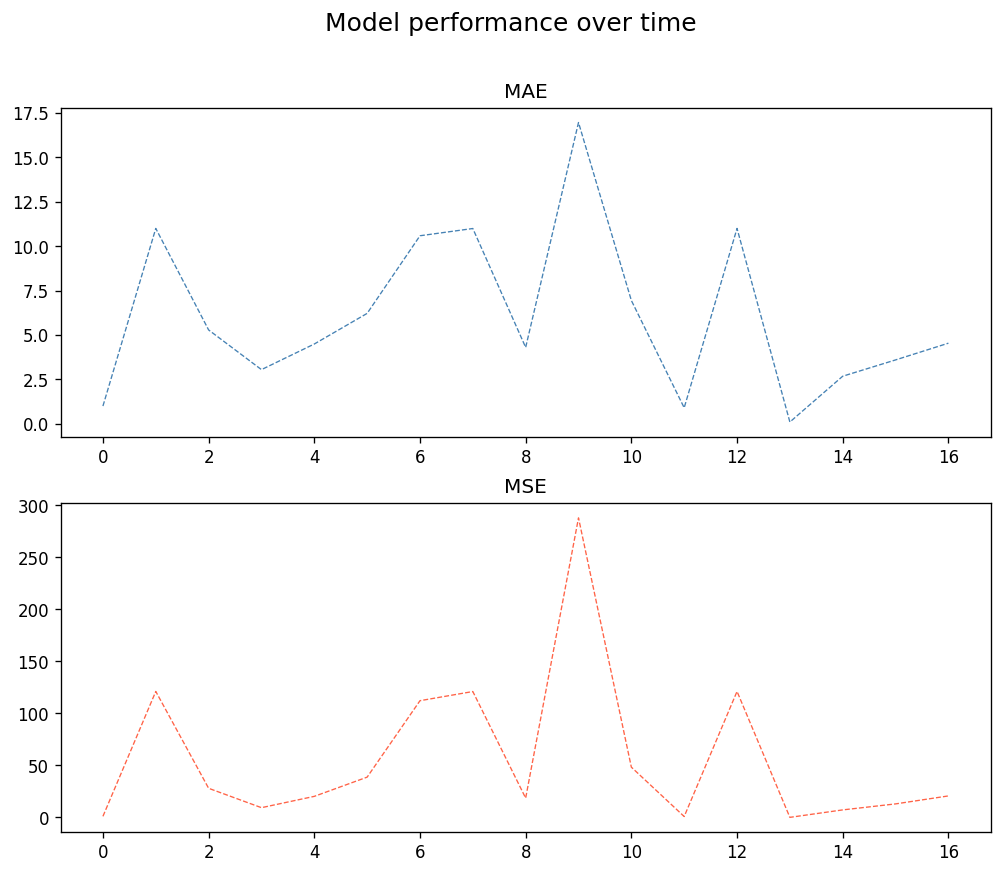

In [30]:
import matplotlib.pyplot as plt

# Append metrics results on lists.
mae = []
mse = []
for i in range(len(results)):
    mae.append(results[i]['metrics']['mae'])
    mse.append(results[i]['metrics']['mse'])

# Generate figure.
fig, axs = plt.subplots(2, figsize=(10,8), dpi=120)

# Plots.
axs[0].plot(mae, linewidth=0.8, color='steelblue', linestyle='--')
axs[1].plot(mse, linewidth=0.8, color='tomato', linestyle='--')


# Set titles.
axs[0].set_title("MAE")
axs[1].set_title("MSE")
fig.suptitle('Model performance over time', fontsize=15)

plt.show()

Voilà!